In [1]:
%pip install torch torchrl gymnasium matplotlib tqdm torchinfo


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from tensordict.nn import TensorDictModule
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymWrapper
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, OneHotCategorical, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm
import torchinfo

In [3]:
if torch.cuda.is_available():
    device = "cuda:0"
# elif torch.backends.mps.is_available():
#     device = "mps:0"
else:
    device = "cpu"

num_cells = 512  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

In [4]:
frame_skip = 1
frames_per_batch = 10000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000_000 // frame_skip

In [5]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [6]:
import semiconductor_env

env = gym.make("SemiconductorEnv-v0")
env = FlattenObservation(env)
base_env = GymWrapper(env, device=device)

/Users/mikemykhaylov/Projects/semiconductor-env/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/Users/mikemykhaylov/Projects/semiconductor-env/venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(


In [7]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(
            in_keys=["observation"],
        ),
        StepCounter(max_steps=10000),
    ),
)

In [8]:
env.transform[0].init_stats(num_iter=10000, reduce_dim=0, cat_dim=0)

In [9]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([40])


In [10]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("done_spec:", env.done_spec)
print("action_spec:", env.action_spec)
print("state_spec:", env.state_spec)

observation_spec: CompositeSpec(
    observation: BoundedTensorSpec(
        shape=torch.Size([40]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([40]), device=cpu, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([40]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
        hi

In [11]:
check_env_specs(env)

check_env_specs succeeded!


In [12]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 7]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([3, 40]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.int64, is_shared=False),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([3]),
            device

In [13]:
actor_net = nn.Sequential(
    nn.Linear(env.observation_spec["observation"].shape[-1], num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, env.action_spec.shape[-1]),
    nn.Softmax(dim=-1),
)

actor_net = actor_net.to(device)

In [14]:
torchinfo.summary(actor_net, input_size=(1, 40))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 7]                    --
├─Linear: 1-1                            [1, 512]                  20,992
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 512]                  262,656
├─ReLU: 1-4                              [1, 512]                  --
├─Linear: 1-5                            [1, 512]                  262,656
├─ReLU: 1-6                              [1, 512]                  --
├─Linear: 1-7                            [1, 7]                    3,591
├─Softmax: 1-8                           [1, 7]                    --
Total params: 549,895
Trainable params: 549,895
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.20
Estimated Total Size (MB): 2.21

In [15]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["logits"]
)

In [16]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["logits"],
    distribution_class=OneHotCategorical,
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

In [17]:
value_net = nn.Sequential(
    nn.Linear(env.observation_spec["observation"].shape[-1], num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, num_cells),
    nn.ReLU(),
    nn.Linear(num_cells, 1),
)

value_net = value_net.to(device)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

let's try our policy and value modules. As we said earlier, the usage of
:class:`TensorDictModule` makes it possible to directly read the output
of the environment to run these modules, as they know what information to read
and where to write it:




In [18]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        logits: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([40]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=to

In [19]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [20]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [21]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

In [22]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        with torch.no_grad():
            advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optim step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    # logs["step_count"].append(tensordict_data["step_count"].max().item())
    # stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            # logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                # f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, lr_str]))

    # We're also using a learning rate scheduler. Like tkhe gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward: -181645440.0000 (init: -633264832.0000), , average reward=-5047895.5000 (init=-5391575.5000), lr policy:  0.0000: 100%|██████████| 10000000/10000000 [13:31:27<00:00, 254.33it/s] 

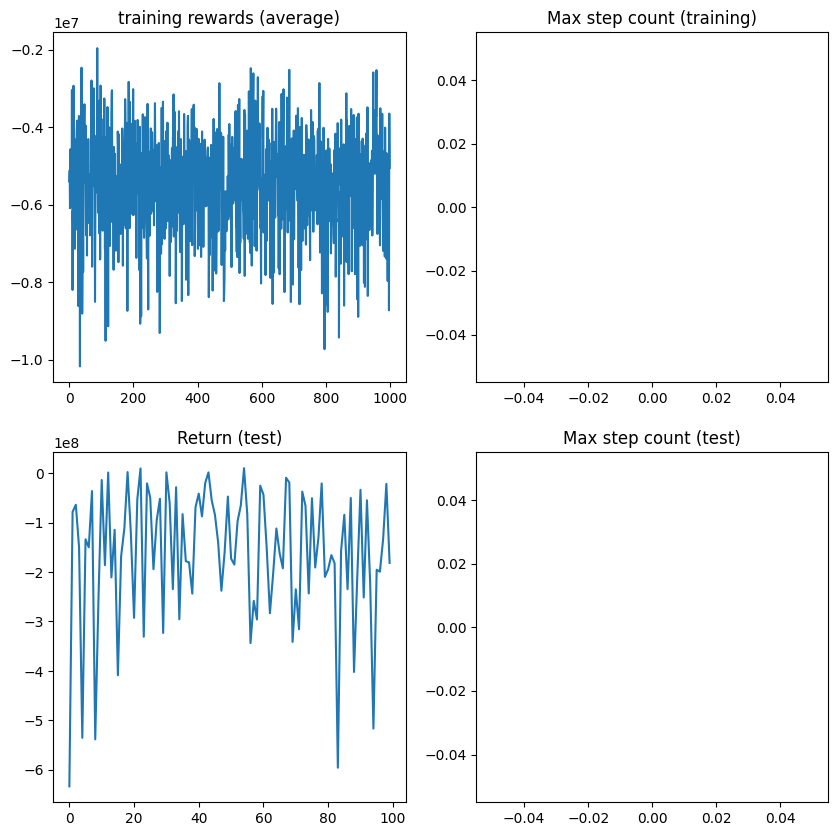

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [24]:
# save model
torch.save(policy_module.state_dict(), "policy_module.pt")
torch.save(value_module.state_dict(), "value_module.pt")